Occupancy Detection based on ECO dataset: Winter
=======================================

In [1]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io as sio

Using TensorFlow backend.


The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [2]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [3]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


The following function plots the losses against the epochs.

In [4]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

The following function calculates the sad: 

In [5]:
def calc_sad(X):
    sad = 0
#     print(X)
#     print('end of X')
    for i in X.index.tolist():
#         print(i)
        if i < X.last_valid_index():
            sad += abs(X[i] - X[i+1])
    return sad

The following function detects the on-off status:

In [6]:
def detect_onoff(X):
    on_off = 0
    thA = 30
    thT = 30
    timecount = 0
    for i in X.index.tolist():
        if i < X.last_valid_index():
#             print(timecount)
            if abs(X[i] - X[i+1]) >= thA:
                timecount += 1
            else:
                timecount = 0
            if timecount == thT:
                on_off += 1
                timecount = 0
    return on_off

In [7]:
from os import walk
path = "C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/01_sm_csv/01"
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break

In [8]:
df={}
for filename in f:
    datestamp = filename[:-4].replace("-","")
    #print(datestamp)
    #if int(datestamp) >= 20120715 and int(datestamp) <= 20120825:
    df[datestamp]=pd.read_csv(path+"/"+filename,header=None,names=["powerallphases","powerl1","powerl2","powerl3","currentneutral","currentl1","currentl2",
                                    "currentl3","voltagel1","voltagel2","voltagel3","phaseanglevoltagel2l1",
                                    "phaseanglevoltagel3l1","phaseanglecurrentvoltagel1","phaseanglecurrentvoltagel2",
                                    "phaseanglecurrentvoltagel3"])
len(df)

245

In [9]:
df2 = pd.read_csv("C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/01_occupancy_csv/01_winter.csv",index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.index = df2.index.strftime('%Y%m%d')
len(df2)

46

In [10]:
import datetime
winter = df2.index.tolist()
df_winter = {}
for key in df.keys():
    if key in winter:
        df_winter[key]=df[key]
len(df_winter)

46

In [11]:
n = 900  #chunk row size
winter_features = pd.DataFrame()
for day, data in df_winter.items():
    list_df_winter = [data[i:i+n] for i in range(0,len(data),n)]
    mean123 = []
    mean1 = []
    mean2 = []
    mean3 = []
    std123 = []
    std1 = []
    std2 = []
    std3 = []
    sad1 = []
    sad2 = []
    sad3 = []
    sad123 = []
    range1 = []
    range2 = []
    range3 = []
    range123 = []
    max123 = []
    max1 = []
    max2 = []
    max3 = []
    min123 = []
    min1 = []
    min2 = []
    min3 = []
    corr123 = []
    corr1 = []
    corr2 = []
    corr3 = []
    onoff123 = []
    onoff1 = []
    onoff2 = []
    onoff3 = []
    
    for chunk in list_df_winter:
        mean123.append(np.mean(chunk['powerallphases']))
        mean1.append(np.mean(chunk['powerl1']))
        mean2.append(np.mean(chunk['powerl2']))
        mean3.append(np.mean(chunk['powerl3']))
        std123.append(np.std(chunk['powerallphases']))
        std1.append(np.std(chunk['powerl1']))
        std2.append(np.std(chunk['powerl2']))
        std3.append(np.std(chunk['powerl3']))
        range123.append(np.amax(chunk['powerallphases'] - np.amin(chunk['powerallphases'])))
        range1.append(np.amax(chunk['powerl1'] - np.amin(chunk['powerl1'])))
        range2.append(np.amax(chunk['powerl2'] - np.amin(chunk['powerl2'])))
        range3.append(np.amax(chunk['powerl3'] - np.amin(chunk['powerl3'])))
        sad123.append(calc_sad(chunk['powerallphases']))
        sad1.append(calc_sad(chunk['powerl1']))
        sad2.append(calc_sad(chunk['powerl2']))
        sad3.append(calc_sad(chunk['powerl3']))
        max123.append(np.amax(chunk['powerallphases']))
        max1.append(np.amax(chunk['powerl1']))
        max2.append(np.amax(chunk['powerl2']))
        max3.append(np.amax(chunk['powerl3']))
        min123.append(np.amin(chunk['powerallphases']))
        min1.append(np.amin(chunk['powerl1']))
        min2.append(np.amin(chunk['powerl2']))
        min3.append(np.amin(chunk['powerl3']))
        corr123.append(chunk['powerallphases'].autocorr(lag=1))
        corr1.append(chunk['powerl1'].autocorr(lag=1))
        corr2.append(chunk['powerl2'].autocorr(lag=1))
        corr3.append(chunk['powerl3'].autocorr(lag=1))
        onoff123.append(detect_onoff(chunk['powerallphases']))
        onoff1.append(detect_onoff(chunk['powerl1']))
        onoff2.append(detect_onoff(chunk['powerl2']))
        onoff3.append(detect_onoff(chunk['powerl3']))
    ptime = list(range(1,97))
    data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
                                            std1,std2,std3,std123,sad1,sad2,sad3,sad123,
                                         corr1,corr2,corr3,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,
                                         range3,range123,ptime)), 
                            columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])
    
    
    winter_features = winter_features.append(data)
winter_features.loc[winter_features.ptime < 25, 'ptime'] = 0
winter_features.loc[winter_features.ptime > 89, 'ptime'] = 0
winter_features = winter_features.loc[(winter_features['ptime'] >0)]
winter_features['ptime'] = winter_features['ptime'] - 24

winter_features

,min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,...,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,range3,range123,ptime
24,31.962,71.367,12.724,117.671,102.451,77.123,13.805,188.432,41.124103,73.951360,...,0.982764,0.0,0.0,0.0,0.0,70.489,5.756,1.081,70.761,1.0
25,61.260,29.305,12.830,103.697,63.140,71.952,14.078,148.094,62.019828,49.629829,...,0.998223,0.0,0.0,0.0,0.0,1.880,42.647,1.248,44.397,2.0
26,31.784,29.146,12.801,74.261,61.818,30.320,13.705,105.087,37.478154,29.718724,...,0.997046,0.0,0.0,0.0,0.0,30.034,1.174,0.904,30.826,3.0
27,31.834,29.286,12.767,74.312,85.537,732.210,711.126,1499.400,44.506607,117.657463,...,0.993711,0.0,0.0,0.0,0.0,53.703,702.924,698.359,1425.088,4.0
28,60.703,62.578,73.014,198.783,62.417,72.426,75.204,208.476,61.504024,69.406020,...,0.518571,0.0,0.0,0.0,0.0,1.714,9.848,2.190,9.693,5.0
29,31.514,67.193,15.231,115.266,61.210,72.769,190.010,291.888,33.517404,69.431001,...,0.990901,0.0,0.0,0.0,0.0,29.696,5.576,174.779,176.622,6.0
30,31.441,120.284,14.628,167.473,232.777,1432.170,71.235,1510.260,70.363117,405.803691,...,0.988963,0.0,0.0,0.0,0.0,201.336,1311.886,56.607,1342.787,7.0
31,31.628,272.136,14.638,319.613,62.321,1492.030,71.154,1569.290,60.562291,367.408303,...,0.978802,0.0,0.0,0.0,0.0,30.693,1219.894,56.516,1249.677,8.0
32,31.615,270.531,14.485,318.229,32.680,1592.100,15.494,1638.900,32.123178,435.213368,...,0.984372,0.0,0.0,0.0,0.0,1.065,1321.569,1.009,1320.671,9.0
33,31.702,186.246,14.667,263.580,87.886,304.316,15.623,405.440,49.470382,265.839304,...,0.997615,0.0,0.0,0.0,0.0,56.184,118.070,0.956,141.860,10.0


In [12]:
n = 900

cuml_list = []
for index,row in df2.iterrows():
    occ_winter = []
    list_oc_winter = [row[i:i+n] for i in range(0,len(row),n)]
    for chunk in list_oc_winter:
        occ_winter.append(np.bincount(chunk).argmax())
    occ_winter = occ_winter[24:89]

    cuml_list.extend(occ_winter)
#     print(len(cuml_list))
occ_winter_data = pd.DataFrame(cuml_list, columns = ['occupancy'])
print(occ_winter_data)  
    

      occupancy
0             1
1             1
2             1
3             1
4             1
5             1
6             1
7             1
8             1
9             1
10            1
11            1
12            1
13            1
14            1
15            0
16            0
17            0
18            0
19            0
20            0
21            0
22            0
23            0
24            0
25            0
26            0
27            0
28            0
29            0
...         ...
2960          1
2961          1
2962          1
2963          1
2964          1
2965          1
2966          1
2967          1
2968          1
2969          1
2970          1
2971          1
2972          1
2973          1
2974          1
2975          1
2976          1
2977          1
2978          1
2979          1
2980          1
2981          1
2982          1
2983          1
2984          1
2985          1
2986          1
2987          1
2988          1
2989          1

[2990 r

Replacing all the 'nan' values by '0'

In [13]:
winter_features[np.isnan(winter_features)] = 0

Model with Manual Validation:
-----------

In [14]:
def init_model(features):
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

Data Pre-processing:


In [15]:
X = np.array(winter_features)
print('X dim: ',X.shape)
y = np.array(occ_winter_data)
print('y dim: ',y.shape)

X = normalize_data(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train dim: ', X_train.shape)
print('X_tesy dim: ', X_test.shape)
print('y_train dim: ', y_train.shape)
print('y_tesy dim: ', y_test.shape)

X dim:  (2990, 33)
y dim:  (2990, 1)
X_train dim:  (2541, 33, 1)
X_tesy dim:  (449, 33, 1)
y_train dim:  (2541, 1)
y_tesy dim:  (449, 1)


In [16]:
features = X_train.shape[1]
model = init_model(features)
model.summary()

W0828 21:03:11.863848  6996 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 21:03:11.884850  6996 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 21:03:11.888850  6996 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 21:03:12.077860  6996 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0828 21:03:12.130863  6996 deprec

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 33, 256)           1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 256)           1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 33, 128)           131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 33, 128)           512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 33, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 33, 64)            32832     
__________

Training and Testing:


Train on 2541 samples, validate on 449 samples
Epoch 1/150
 - 8s - loss: 0.5804 - acc: 0.7348 - val_loss: 0.3905 - val_acc: 0.8641
Epoch 2/150
 - 4s - loss: 0.4224 - acc: 0.8257 - val_loss: 0.3181 - val_acc: 0.8686
Epoch 3/150
 - 4s - loss: 0.3865 - acc: 0.8414 - val_loss: 0.3277 - val_acc: 0.8597
Epoch 4/150
 - 4s - loss: 0.3658 - acc: 0.8481 - val_loss: 0.3106 - val_acc: 0.8641
Epoch 5/150
 - 4s - loss: 0.3550 - acc: 0.8579 - val_loss: 0.2864 - val_acc: 0.8820
Epoch 6/150
 - 4s - loss: 0.3366 - acc: 0.8556 - val_loss: 0.2973 - val_acc: 0.8753
Epoch 7/150
 - 4s - loss: 0.3288 - acc: 0.8646 - val_loss: 0.2802 - val_acc: 0.8909
Epoch 8/150
 - 4s - loss: 0.3297 - acc: 0.8599 - val_loss: 0.2739 - val_acc: 0.8820
Epoch 9/150
 - 4s - loss: 0.3168 - acc: 0.8662 - val_loss: 0.3600 - val_acc: 0.8374
Epoch 10/150
 - 4s - loss: 0.3238 - acc: 0.8611 - val_loss: 0.2776 - val_acc: 0.8842
Epoch 11/150
 - 4s - loss: 0.3170 - acc: 0.8599 - val_loss: 0.2852 - val_acc: 0.8731
Epoch 12/150
 - 4s - loss: 

Epoch 97/150
 - 4s - loss: 0.1520 - acc: 0.9319 - val_loss: 0.2657 - val_acc: 0.8909
Epoch 98/150
 - 4s - loss: 0.1739 - acc: 0.9221 - val_loss: 0.2467 - val_acc: 0.9065
Epoch 99/150
 - 4s - loss: 0.1524 - acc: 0.9319 - val_loss: 0.2532 - val_acc: 0.8931
Epoch 100/150
 - 5s - loss: 0.1597 - acc: 0.9315 - val_loss: 0.2509 - val_acc: 0.8998
Epoch 101/150
 - 4s - loss: 0.1509 - acc: 0.9362 - val_loss: 0.2795 - val_acc: 0.8886
Epoch 102/150
 - 4s - loss: 0.1496 - acc: 0.9327 - val_loss: 0.2514 - val_acc: 0.8998
Epoch 103/150
 - 4s - loss: 0.1448 - acc: 0.9433 - val_loss: 0.2601 - val_acc: 0.8931
Epoch 104/150
 - 4s - loss: 0.1536 - acc: 0.9343 - val_loss: 0.2813 - val_acc: 0.8842
Epoch 105/150
 - 4s - loss: 0.1498 - acc: 0.9374 - val_loss: 0.2737 - val_acc: 0.8864
Epoch 106/150
 - 4s - loss: 0.1590 - acc: 0.9315 - val_loss: 0.2565 - val_acc: 0.8953
Epoch 107/150
 - 4s - loss: 0.1562 - acc: 0.9303 - val_loss: 0.2502 - val_acc: 0.8886
Epoch 108/150
 - 4s - loss: 0.1495 - acc: 0.9303 - val_lo

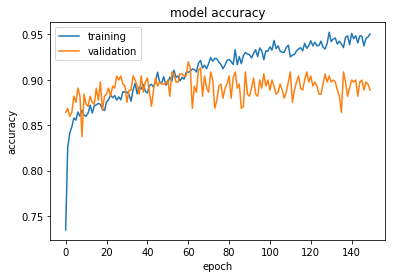

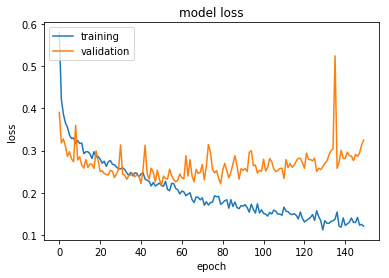

In [17]:
history = LossHistory()
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

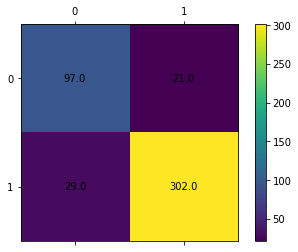

In [18]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test,model):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()

conf_matrix(X_test,y_test,model)


In [62]:
tn, fp, fn, tp = confusion_matrix(X_test,y_test).ravel()

ValueError: Classification metrics can't handle a mix of unknown and binary targets

Classification accuracy: 88.86

Early Stopping:
------

In [19]:
model = init_model(features)

Training and Testing:


Train on 2541 samples, validate on 449 samples
Epoch 1/150
 - 8s - loss: 0.5414 - acc: 0.7631 - val_loss: 0.3768 - val_acc: 0.8820
Epoch 2/150
 - 4s - loss: 0.4327 - acc: 0.8194 - val_loss: 0.3359 - val_acc: 0.8775
Epoch 3/150
 - 4s - loss: 0.3761 - acc: 0.8457 - val_loss: 0.3133 - val_acc: 0.8686
Epoch 4/150
 - 4s - loss: 0.3601 - acc: 0.8544 - val_loss: 0.3096 - val_acc: 0.8753
Epoch 5/150
 - 4s - loss: 0.3420 - acc: 0.8552 - val_loss: 0.2837 - val_acc: 0.8775
Epoch 6/150
 - 4s - loss: 0.3294 - acc: 0.8587 - val_loss: 0.2891 - val_acc: 0.8686
Epoch 7/150
 - 4s - loss: 0.3281 - acc: 0.8654 - val_loss: 0.2832 - val_acc: 0.8731
Epoch 8/150
 - 4s - loss: 0.3307 - acc: 0.8595 - val_loss: 0.2819 - val_acc: 0.8708
Epoch 9/150
 - 4s - loss: 0.3208 - acc: 0.8666 - val_loss: 0.2666 - val_acc: 0.8753
Epoch 10/150
 - 4s - loss: 0.3019 - acc: 0.8693 - val_loss: 0.2645 - val_acc: 0.8820
Epoch 11/150
 - 4s - loss: 0.3044 - acc: 0.8646 - val_loss: 0.2564 - val_acc: 0.8775
Epoch 12/150
 - 4s - loss: 

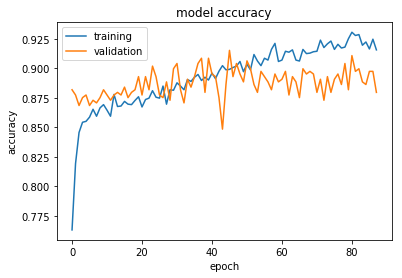

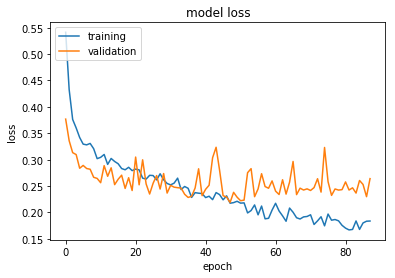

In [20]:
history_e = LossHistory()
es_e = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_e = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[history_e,es_e],
                validation_data=(X_test,y_test), verbose=2)
score_e = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score_e)

plt.plot(hiss_e.history['acc'])
plt.plot(hiss_e.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_e.history['loss'])
plt.plot(hiss_e.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

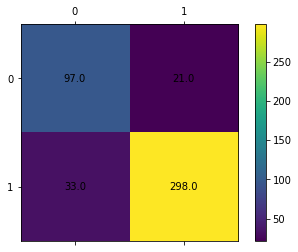

In [21]:
conf_matrix(X_test,y_test,model)

Model with K-fold Validation:
----------

Epoch 00095: early stopping
acc: 88.08%


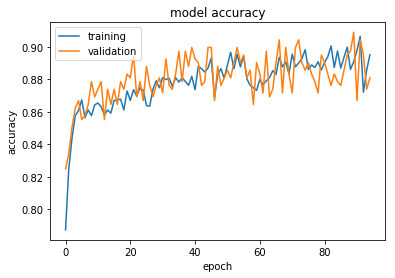

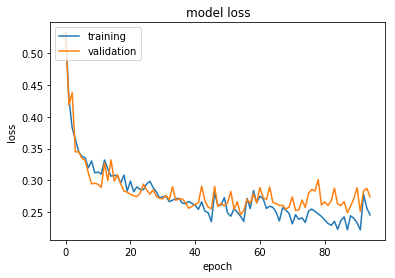

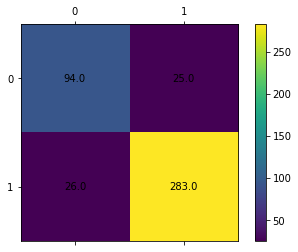

Epoch 00081: early stopping
acc: 87.15%


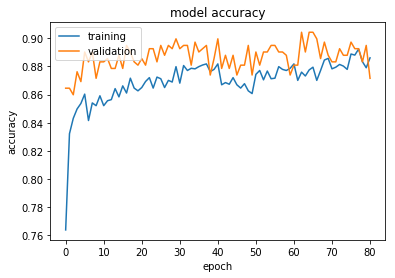

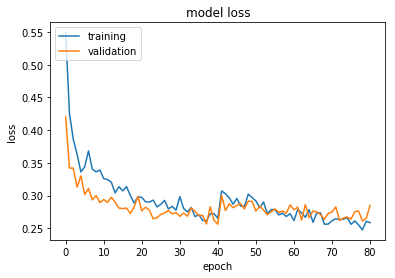

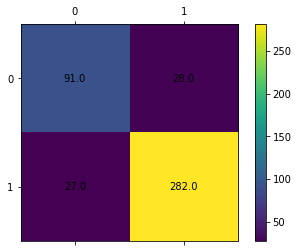

Epoch 00122: early stopping
acc: 87.59%


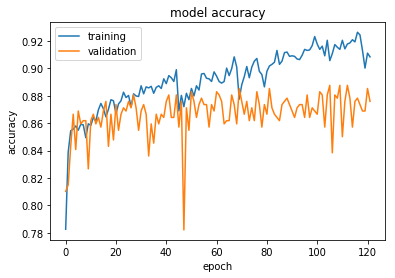

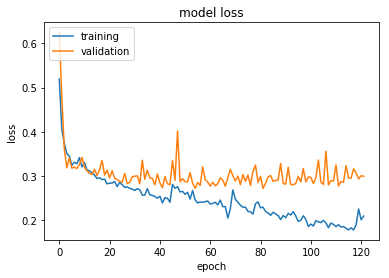

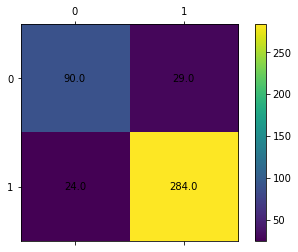

Epoch 00121: early stopping
acc: 87.82%


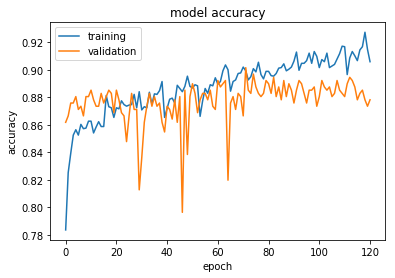

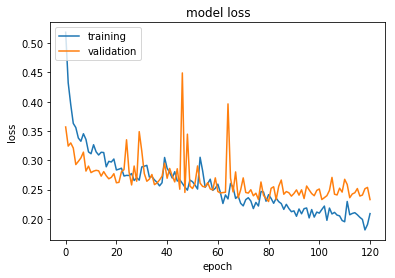

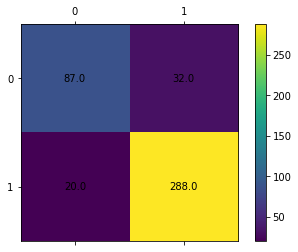

Epoch 00093: early stopping
acc: 87.35%


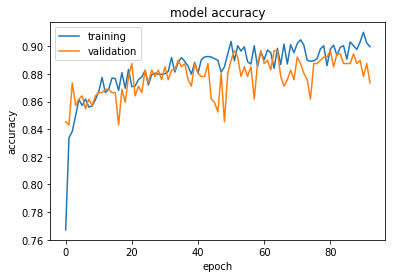

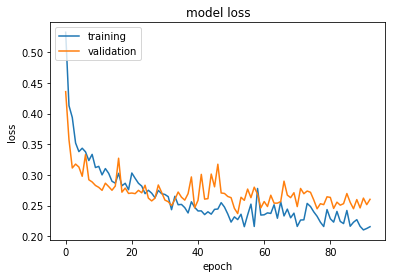

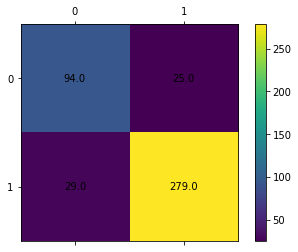

Epoch 00122: early stopping
acc: 86.89%


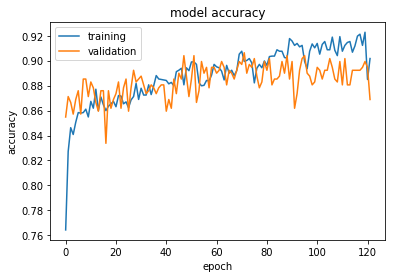

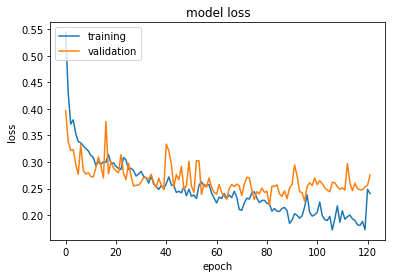

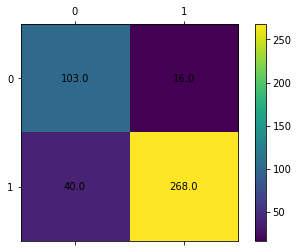

Epoch 00138: early stopping
acc: 88.73%


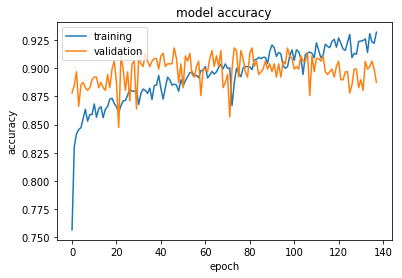

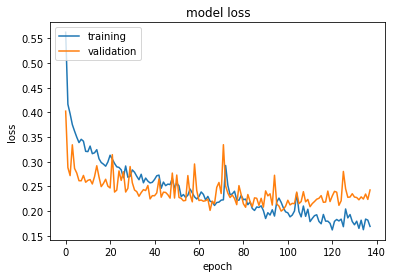

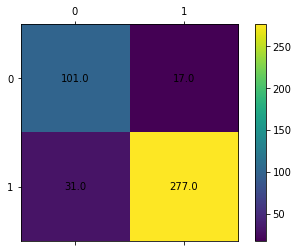

In [25]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
loss = []
for train, test in kfold.split(X, y):
    
    model = init_model(features)
    
    X_train_k =X[train].reshape(X[train].shape[0], X[train].shape[1], 1)
    X_test_k = X[test].reshape(X[test].shape[0], X[test].shape[1], 1)
    history_k = LossHistory()
    es_k = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_k = model.fit(X_train_k, y[train], epochs=150, batch_size=32,
                callbacks=[history_k,es_k],
                validation_data=(X_test_k,y[test]), verbose=0)
    scores_k = model.evaluate(X_test_k, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_k[1]*100))
    cvscores.append(scores_k[1] * 100)
    loss.append(scores_k[0])
#     print(score)
    plt.plot(hiss_k.history['acc'])
    plt.plot(hiss_k.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_k.history['loss'])
    plt.plot(hiss_k.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_k,y[test],model)


In [26]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss), np.std(loss)))

accuracy::  87.66% (+/- 0.58%)
error:: 0.27 (+/- 0.02)


Shapely Values:
-------

In [27]:
import shap

# select a set of background examples to take an expectation over
background = X_train
X_train.shape

(2541, 33, 1)

In [28]:
model = init_model(features)
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
shap_values = e.shap_values(X_train)

In [29]:
shap_values[0]= shap_values[0].reshape(shap_values[0].shape[0],shap_values[0].shape[1])
shap_values[0].shape

X_postprocess = X_train.reshape(X_train.shape[0],X_train.shape[1])
X_postprocess.shape

(2541, 33)

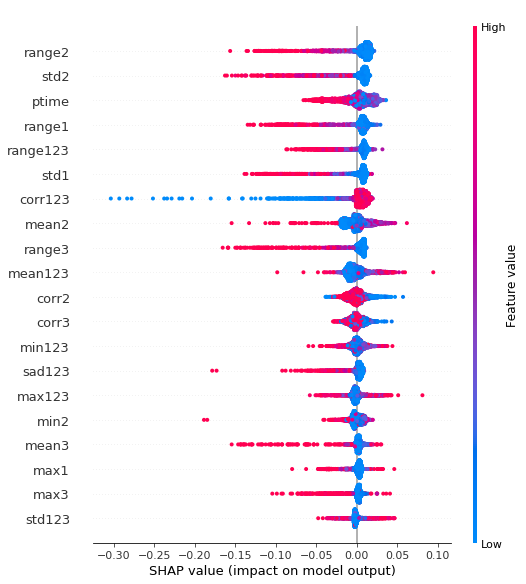

In [30]:
shap.summary_plot(shap_values[0], X_postprocess, feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

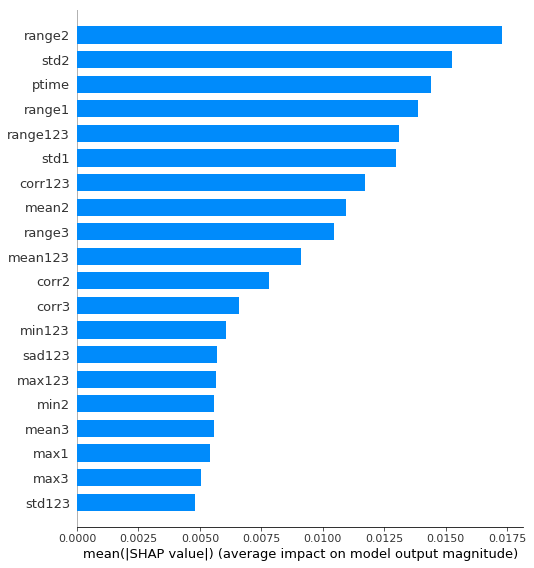

In [31]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar", feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

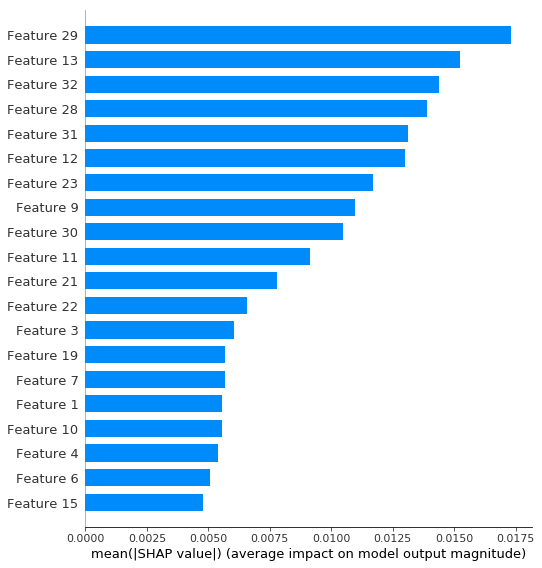

In [32]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar")

After Feature Reduction by Shapely Values
-------------

In [35]:
new_winter_features = np.concatenate((X[:,1][:, np.newaxis], X[:,3:5],X[:,6:8],X[:,9:14],X[:,15][:, np.newaxis],X[:,19][:, np.newaxis],X[:,21:24], X[:,28:33]),axis=1) 
new_winter_features.shape


(2990, 20)

In [40]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(new_winter_features, y, test_size=0.15, shuffle=True)

X_train_s = X_train_s.reshape(X_train_s.shape[0], X_train_s.shape[1], 1)
X_test_s = X_test_s.reshape(X_test_s.shape[0], X_test_s.shape[1], 1)

print('X_train dim: ', X_train_s.shape)
print('X_tesy dim: ', X_test_s.shape)
print('y_train dim: ', y_train_s.shape)
print('y_tesy dim: ', y_test_s.shape)

X_train dim:  (2541, 20, 1)
X_tesy dim:  (449, 20, 1)
y_train dim:  (2541, 1)
y_tesy dim:  (449, 1)


In [41]:
model = init_model(20)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 20, 256)           1280      
_________________________________________________________________
batch_normalization_79 (Batc (None, 20, 256)           1024      
_________________________________________________________________
dropout_79 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 20, 128)           131200    
_________________________________________________________________
batch_normalization_80 (Batc (None, 20, 128)           512       
_________________________________________________________________
dropout_80 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 20, 64)            32832     
__________

Train on 2541 samples, validate on 449 samples
Epoch 1/150
 - 16s - loss: 0.5564 - acc: 0.7525 - val_loss: 0.4581 - val_acc: 0.8085
Epoch 2/150
 - 2s - loss: 0.4178 - acc: 0.8430 - val_loss: 0.4505 - val_acc: 0.8151
Epoch 3/150
 - 2s - loss: 0.3831 - acc: 0.8548 - val_loss: 0.3610 - val_acc: 0.8241
Epoch 4/150
 - 2s - loss: 0.3559 - acc: 0.8508 - val_loss: 0.3701 - val_acc: 0.8218
Epoch 5/150
 - 2s - loss: 0.3350 - acc: 0.8662 - val_loss: 0.3684 - val_acc: 0.8196
Epoch 6/150
 - 2s - loss: 0.3377 - acc: 0.8556 - val_loss: 0.3641 - val_acc: 0.8285
Epoch 7/150
 - 2s - loss: 0.3301 - acc: 0.8638 - val_loss: 0.3709 - val_acc: 0.8129
Epoch 8/150
 - 4s - loss: 0.3248 - acc: 0.8611 - val_loss: 0.3572 - val_acc: 0.8263
Epoch 9/150
 - 3s - loss: 0.3181 - acc: 0.8638 - val_loss: 0.3427 - val_acc: 0.8307
Epoch 10/150
 - 4s - loss: 0.3208 - acc: 0.8627 - val_loss: 0.3368 - val_acc: 0.8396
Epoch 11/150
 - 4s - loss: 0.3058 - acc: 0.8701 - val_loss: 0.3512 - val_acc: 0.8263
Epoch 12/150
 - 4s - loss:

Epoch 97/150
 - 4s - loss: 0.1956 - acc: 0.9162 - val_loss: 0.2919 - val_acc: 0.8619
Epoch 98/150
 - 4s - loss: 0.1829 - acc: 0.9193 - val_loss: 0.3020 - val_acc: 0.8641
Epoch 99/150
 - 4s - loss: 0.1651 - acc: 0.9280 - val_loss: 0.3765 - val_acc: 0.8641
Epoch 100/150
 - 4s - loss: 0.1829 - acc: 0.9185 - val_loss: 0.3359 - val_acc: 0.8396
Epoch 101/150
 - 4s - loss: 0.1693 - acc: 0.9303 - val_loss: 0.3002 - val_acc: 0.8664
Epoch 102/150
 - 4s - loss: 0.1689 - acc: 0.9296 - val_loss: 0.3604 - val_acc: 0.8686
Epoch 103/150
 - 4s - loss: 0.1804 - acc: 0.9264 - val_loss: 0.3283 - val_acc: 0.8619
Epoch 104/150
 - 4s - loss: 0.1717 - acc: 0.9288 - val_loss: 0.3086 - val_acc: 0.8575
Epoch 105/150
 - 4s - loss: 0.1736 - acc: 0.9296 - val_loss: 0.2877 - val_acc: 0.8775
Epoch 106/150
 - 4s - loss: 0.1823 - acc: 0.9189 - val_loss: 0.3098 - val_acc: 0.8753
Epoch 107/150
 - 4s - loss: 0.1730 - acc: 0.9248 - val_loss: 0.2882 - val_acc: 0.8753
Epoch 108/150
 - 4s - loss: 0.1720 - acc: 0.9264 - val_lo

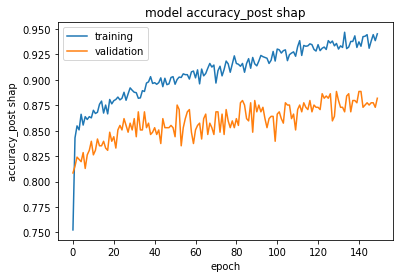

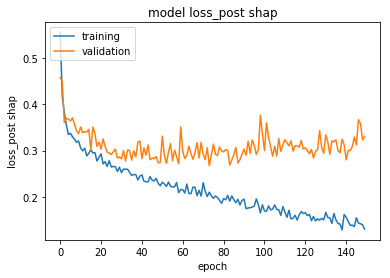

In [43]:
history1 = LossHistory()
hiss1 = model.fit(X_train_s, y_train_s, epochs=150, batch_size=32,
                callbacks=[history1],
                validation_data=(X_test_s,y_test_s), verbose=2)
score1 = model.evaluate(X_test_s, y_test_s, batch_size=32)
print(score1)
plt.plot(hiss1.history['acc'])
plt.plot(hiss1.history['val_acc'])
plt.title('model accuracy_post shap')
plt.ylabel('accuracy_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss1.history['loss'])
plt.plot(hiss1.history['val_loss'])
plt.title('model loss_post shap')
plt.ylabel('loss_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

y_pred = model.predict(X_test_s)

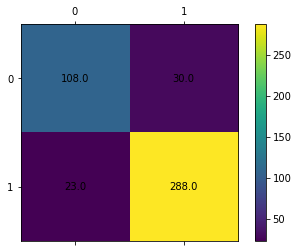

In [44]:
conf_matrix(X_test_s,y_test_s,model)

Early Stopping:
------

Train on 2541 samples, validate on 449 samples
Epoch 1/150
 - 15s - loss: 0.5526 - acc: 0.7529 - val_loss: 0.5868 - val_acc: 0.7929
Epoch 2/150
 - 4s - loss: 0.4141 - acc: 0.8351 - val_loss: 0.4160 - val_acc: 0.8241
Epoch 3/150
 - 4s - loss: 0.3727 - acc: 0.8520 - val_loss: 0.3721 - val_acc: 0.8374
Epoch 4/150
 - 4s - loss: 0.3550 - acc: 0.8571 - val_loss: 0.3557 - val_acc: 0.8352
Epoch 5/150
 - 4s - loss: 0.3543 - acc: 0.8571 - val_loss: 0.3391 - val_acc: 0.8374
Epoch 6/150
 - 4s - loss: 0.3261 - acc: 0.8697 - val_loss: 0.3849 - val_acc: 0.8151
Epoch 7/150
 - 4s - loss: 0.3248 - acc: 0.8686 - val_loss: 0.3337 - val_acc: 0.8441
Epoch 8/150
 - 4s - loss: 0.3148 - acc: 0.8686 - val_loss: 0.3365 - val_acc: 0.8463
Epoch 9/150
 - 4s - loss: 0.3202 - acc: 0.8638 - val_loss: 0.3523 - val_acc: 0.8151
Epoch 10/150
 - 4s - loss: 0.3069 - acc: 0.8701 - val_loss: 0.3281 - val_acc: 0.8330
Epoch 11/150
 - 4s - loss: 0.3047 - acc: 0.8642 - val_loss: 0.3209 - val_acc: 0.8419
Epoch 12/150
 - 4s - loss:

Epoch 97/150
 - 4s - loss: 0.1784 - acc: 0.9244 - val_loss: 0.3030 - val_acc: 0.8664
Epoch 98/150
 - 4s - loss: 0.1720 - acc: 0.9213 - val_loss: 0.3250 - val_acc: 0.8575
Epoch 99/150
 - 4s - loss: 0.1728 - acc: 0.9260 - val_loss: 0.3863 - val_acc: 0.8552
Epoch 00099: early stopping
449/449 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 508us/step
loss and accuracy::  [0.38627677591712545, 0.8552338530066815]


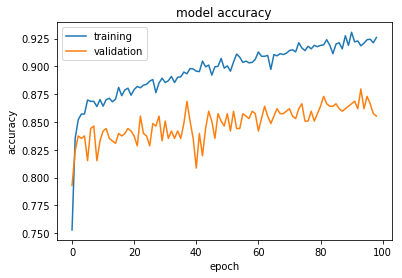

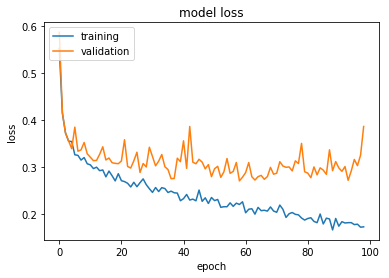

In [45]:
model = init_model(20)

history_se = LossHistory()
es_se = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_se = model.fit(X_train_s, y_train_s, epochs=150, batch_size=32,
                callbacks=[history,es_se],
                validation_data=(X_test_s,y_test_s), verbose=2)
score_se = model.evaluate(X_test_s, y_test_s, batch_size=32)
print('loss and accuracy:: ',score_se)

plt.plot(hiss_se.history['acc'])
plt.plot(hiss_se.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_se.history['loss'])
plt.plot(hiss_se.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

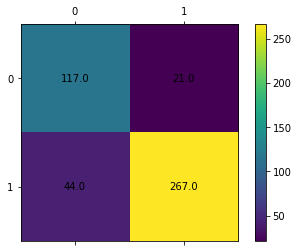

In [46]:
conf_matrix(X_test_s,y_test_s,model)

Model with k-fold Validation:
-------

Epoch 00136: early stopping
acc: 90.19%


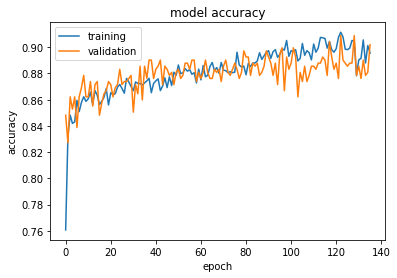

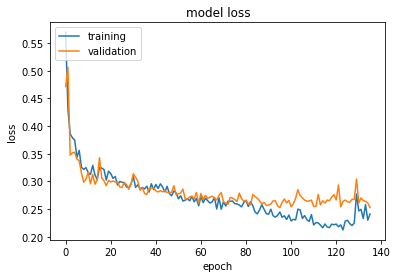

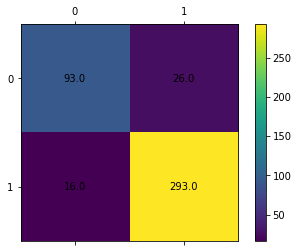

Epoch 00126: early stopping
acc: 88.79%


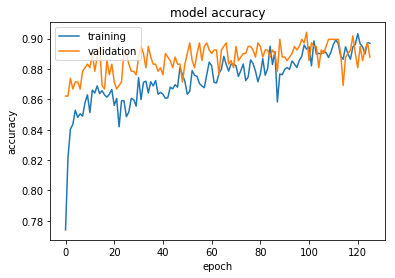

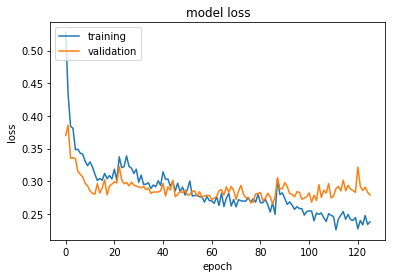

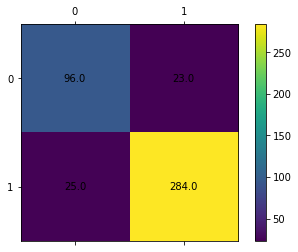

Epoch 00135: early stopping
acc: 86.65%


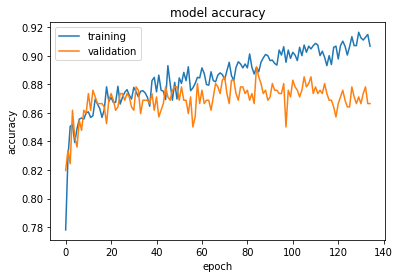

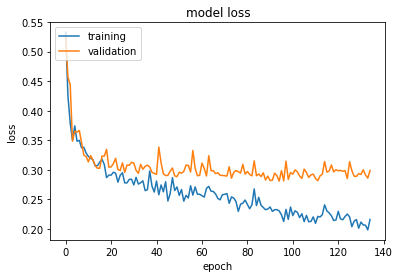

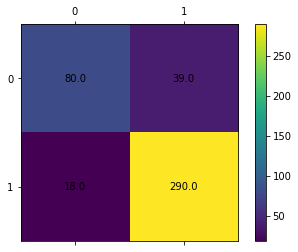

acc: 88.99%


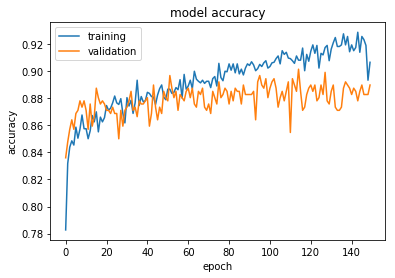

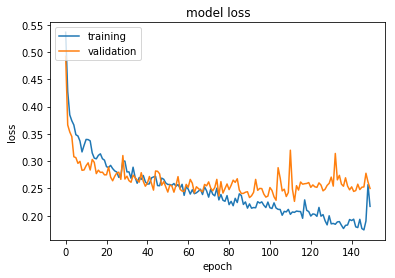

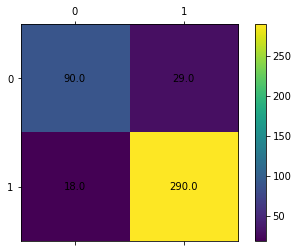

acc: 88.52%


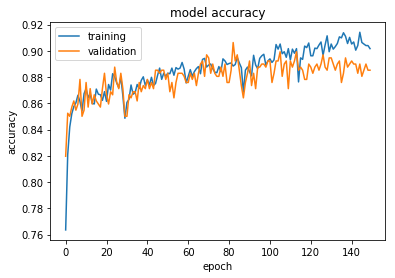

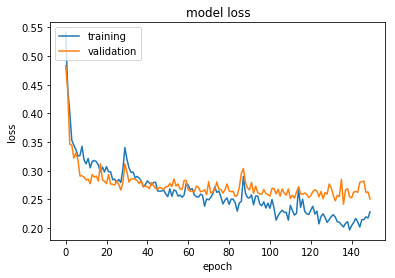

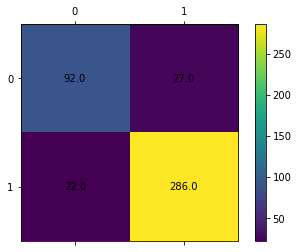

acc: 88.52%


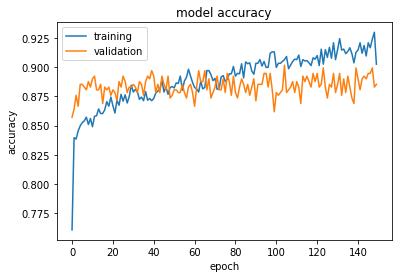

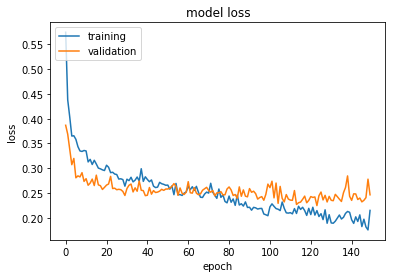

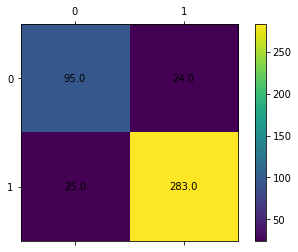

Epoch 00088: early stopping
acc: 89.20%


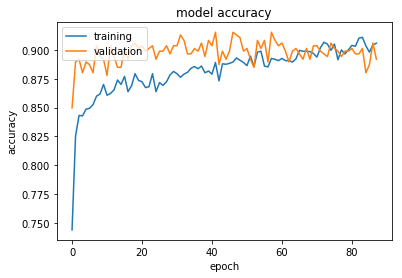

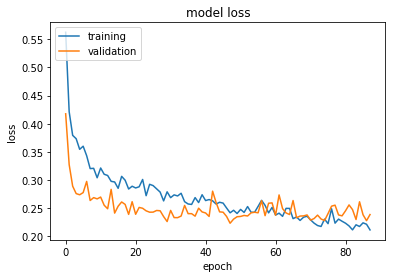

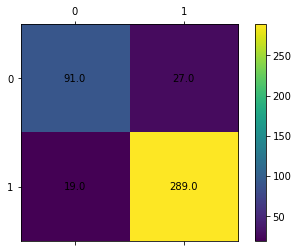

In [48]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold_s = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores_s = []
loss_s = []
XX = new_winter_features
for train, test in kfold_s.split(XX, y):
    
    model = init_model(20)
    
    X_train_ks =XX[train].reshape(XX[train].shape[0], XX[train].shape[1], 1)
    X_test_ks = XX[test].reshape(XX[test].shape[0], XX[test].shape[1], 1)
    history_ks = LossHistory()
    es_ks = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_ks = model.fit(X_train_ks, y[train], epochs=150, batch_size=32,
                callbacks=[history_ks,es_ks],
                validation_data=(X_test_ks,y[test]), verbose=0)
    scores_ks = model.evaluate(X_test_ks, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_ks[1]*100))
    cvscores_s.append(scores_ks[1] * 100)
    loss_s.append(scores_ks[0])
#     print(score)
    plt.plot(hiss_ks.history['acc'])
    plt.plot(hiss_ks.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_ks.history['loss'])
    plt.plot(hiss_ks.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_ks,y[test],model)

In [49]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_s), np.std(cvscores_s)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss_s), np.std(loss_s)))

accuracy::  88.70% (+/- 0.99%)
error:: 0.26 (+/- 0.02)


Shapely+SVM:
------

In [73]:
from sklearn.svm import SVC

# X_train_s = X_train_s.reshape(X_train_s.shape[0], X_train_s.shape[1])
# X_test_s = X_test_s.reshape(X_test_s.shape[0], X_test_s.shape[1])

X_train_sv, X_test_sv, y_train_sv, y_test_sv = train_test_split(new_winter_features, y, test_size=0.15, shuffle=True)
print('X_train dim: ', X_train_sv.shape)
print('X_tesy dim: ', X_test_sv.shape)
print('y_train dim: ', y_train_sv.shape)
print('y_tesy dim: ', y_test_sv.shape)

svclassifier = SVC()
svclassifier.fit(X_train_sv, y_train_sv)

X_train dim:  (2541, 20)
X_tesy dim:  (449, 20)
y_train dim:  (2541, 1)
y_tesy dim:  (449, 1)


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

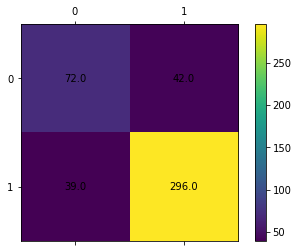

In [74]:
y_pred_s = svclassifier.predict(X_test_sv)
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix,accuracy_score 
y_pred_s[y_pred_s > 0.5] = 1
y_pred_s[y_pred_s <= 0.5] = 0
cm = confusion_matrix(y_test_sv, y_pred_s)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cm)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 85.05%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 86.68%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 84.54%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 85.48%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 83.84%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 87.12%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 87.56%
85.75% (+/- 1.29%)


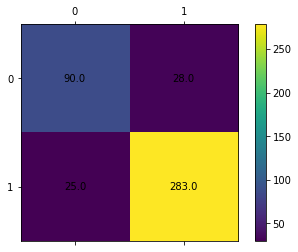

In [78]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score 
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(XX, y):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = XX[train]
    X_test = XX[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, y[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(y[test], y_pred)
    acc = accuracy_score(y[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

PCA:
-------

In [50]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.99)

In [51]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [52]:
pca.n_components_

17

In [53]:
winter_pca = pca.transform(X)

In [54]:
winter_pca.shape

(2990, 17)

In [55]:
from sklearn.model_selection import train_test_split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(winter_pca, y, test_size=0.15, shuffle=True)

In [56]:
X_train_p.shape

(2541, 17)

Early Stopping:
------

In [57]:
features_p = X_train_p.shape[1]
model = init_model(features_p)

X_train_p = X_train_p.reshape(X_train_p.shape[0], X_train_p.shape[1], 1)
X_test_p = X_test_p.reshape(X_test_p.shape[0], X_test_p.shape[1], 1)

print('X_train dim: ', X_train_p.shape)
print('X_tesy dim: ', X_test_p.shape)
print('y_train dim: ', y_train_p.shape)
print('y_tesy dim: ', y_test_p.shape)

X_train dim:  (2541, 17, 1)
X_tesy dim:  (449, 17, 1)
y_train dim:  (2541, 1)
y_tesy dim:  (449, 1)


Train on 2541 samples, validate on 449 samples
Epoch 1/150
 - 21s - loss: 0.5920 - acc: 0.7340 - val_loss: 0.4617 - val_acc: 0.8151
Epoch 2/150
 - 6s - loss: 0.4473 - acc: 0.8111 - val_loss: 0.3885 - val_acc: 0.8552
Epoch 3/150
 - 6s - loss: 0.3953 - acc: 0.8406 - val_loss: 0.3493 - val_acc: 0.8597
Epoch 4/150
 - 6s - loss: 0.3701 - acc: 0.8426 - val_loss: 0.3678 - val_acc: 0.8463
Epoch 5/150
 - 6s - loss: 0.3606 - acc: 0.8375 - val_loss: 0.3290 - val_acc: 0.8619
Epoch 6/150
 - 6s - loss: 0.3371 - acc: 0.8567 - val_loss: 0.3241 - val_acc: 0.8686
Epoch 7/150
 - 6s - loss: 0.3457 - acc: 0.8457 - val_loss: 0.3234 - val_acc: 0.8530
Epoch 8/150
 - 6s - loss: 0.3238 - acc: 0.8587 - val_loss: 0.3256 - val_acc: 0.8552
Epoch 9/150
 - 5s - loss: 0.3287 - acc: 0.8599 - val_loss: 0.3142 - val_acc: 0.8597
Epoch 10/150
 - 6s - loss: 0.3193 - acc: 0.8556 - val_loss: 0.3183 - val_acc: 0.8575
Epoch 11/150
 - 6s - loss: 0.3150 - acc: 0.8571 - val_loss: 0.3166 - val_acc: 0.8641
Epoch 12/150
 - 6s - loss:

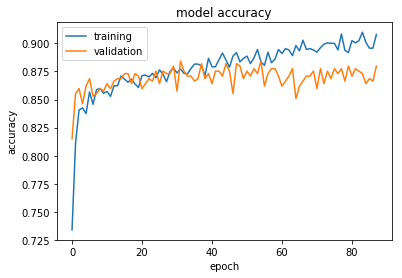

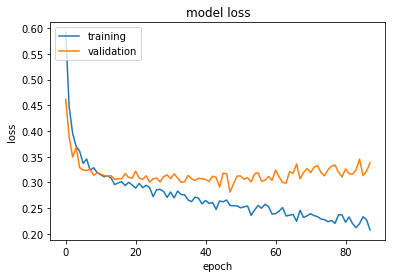

In [58]:
history_pe = LossHistory()
es_pe = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_pe = model.fit(X_train_p, y_train_p, epochs=150, batch_size=32,
                callbacks=[history_pe,es_pe],
                validation_data=(X_test_p,y_test_p), verbose=2)
score_pe = model.evaluate(X_test_p, y_test_p, batch_size=32)
print('loss and accuracy:: ',score_pe)

plt.plot(hiss_pe.history['acc'])
plt.plot(hiss_pe.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_pe.history['loss'])
plt.plot(hiss_pe.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

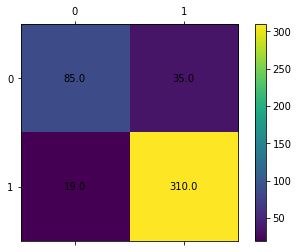

In [59]:
conf_matrix(X_test_p,y_test_p,model)

Model with K fold:
-------------

acc: 88.79%


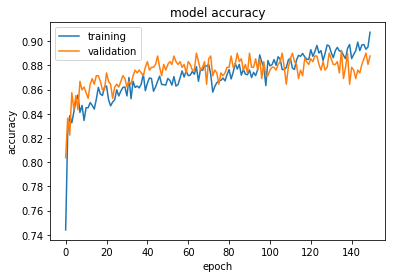

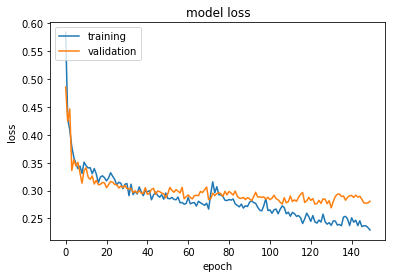

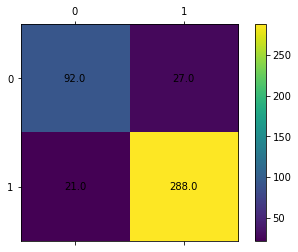

Epoch 00125: early stopping
acc: 87.85%


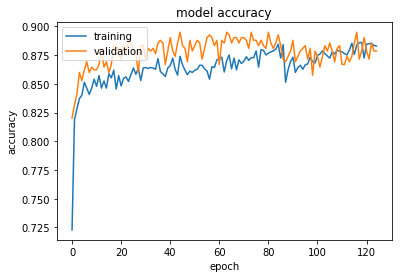

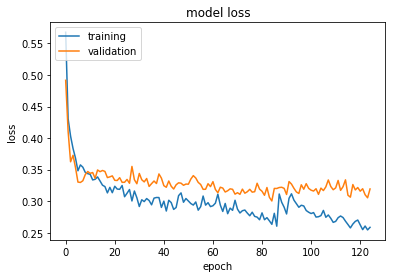

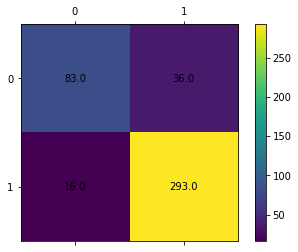

Epoch 00106: early stopping
acc: 86.18%


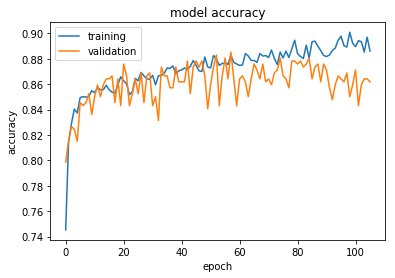

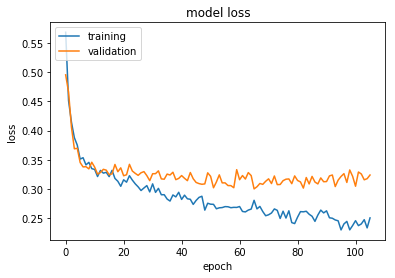

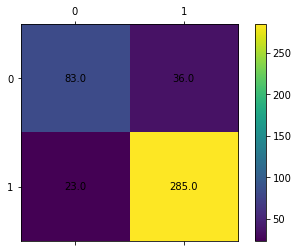

Epoch 00086: early stopping
acc: 85.48%


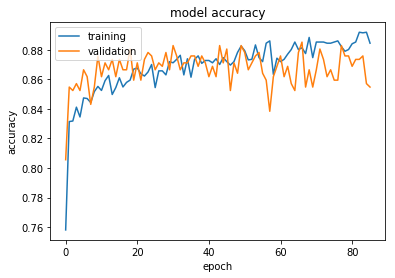

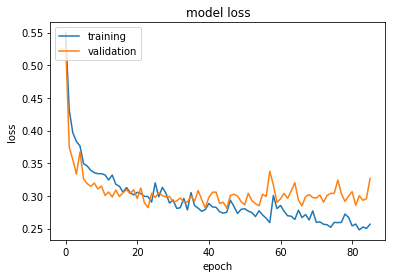

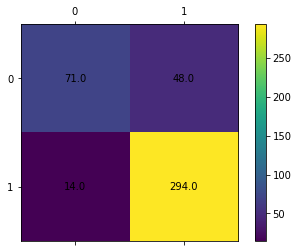

Epoch 00104: early stopping
acc: 87.82%


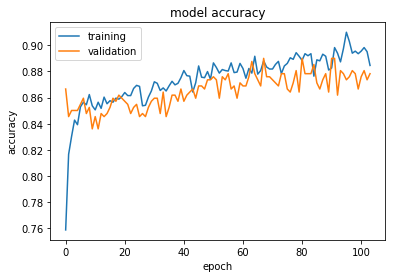

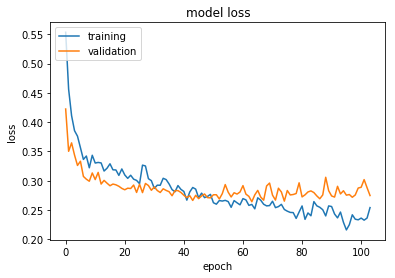

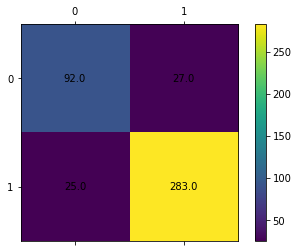

Epoch 00144: early stopping
acc: 88.52%


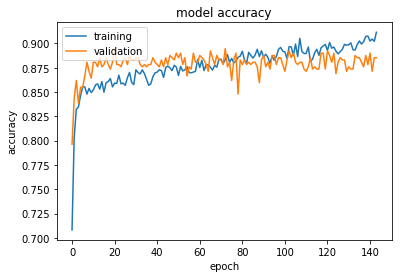

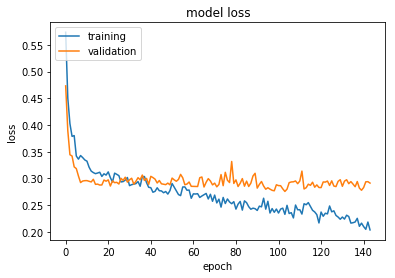

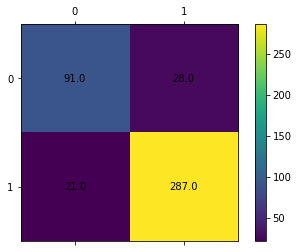

Epoch 00114: early stopping
acc: 88.50%


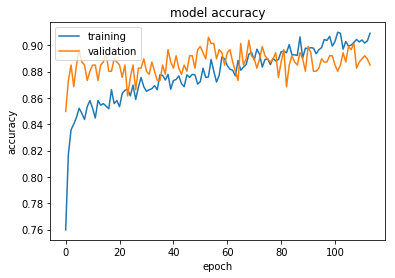

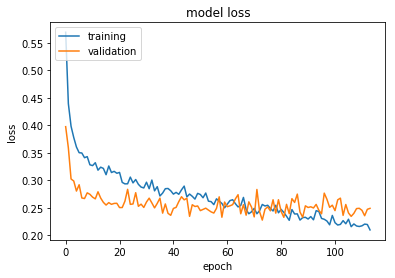

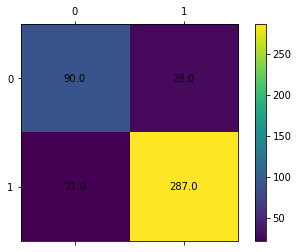

In [81]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold_p = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores_p = []
loss_p = []
XXX = winter_pca
for train, test in kfold_s.split(XXX, y):
    
    model = init_model(features_p)
    
    X_train_kp =XXX[train].reshape(XXX[train].shape[0], XXX[train].shape[1], 1)
    X_test_kp = XXX[test].reshape(XXX[test].shape[0], XXX[test].shape[1], 1)
    history_kp = LossHistory()
    es_kp = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_kp = model.fit(X_train_kp, y[train], epochs=150, batch_size=32,
                callbacks=[history_kp,es_kp],
                validation_data=(X_test_kp,y[test]), verbose=0)
    scores_kp = model.evaluate(X_test_kp, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_kp[1]*100))
    cvscores_p.append(scores_kp[1] * 100)
    loss_p.append(scores_kp[0])
#     print(score)
    plt.plot(hiss_kp.history['acc'])
    plt.plot(hiss_kp.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_kp.history['loss'])
    plt.plot(hiss_kp.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_kp,y[test],model)

In [82]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_p), np.std(cvscores_p)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss_p), np.std(loss_p)))

accuracy::  87.59% (+/- 1.18%)
error:: 0.30 (+/- 0.03)


PCA+SVM
------------

C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 85.51%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 86.92%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 85.25%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 86.42%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 84.07%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 87.59%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 88.03%
86.25% (+/- 1.29%)


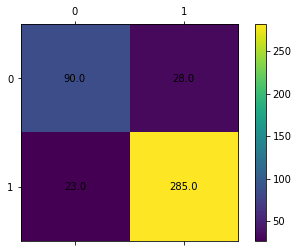

In [79]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score 
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(XXX, y):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = XXX[train]
    X_test = XXX[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, y[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(y[test], y_pred)
    acc = accuracy_score(y[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()